## Import necessary packages

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from utils import *
from model import SiameseNetwork
from loss import ContrastiveLoss
from dataset import ATATContrast
from torchsummary import summary
from matplotlib import pyplot as plt
import os
from glob import glob
import random
from sklearn.metrics import classification_report
import shutil
from tqdm import tqdm

# Prepare the data file

In [2]:
# os.mkdir("train_test_val")
# os.mkdir("train_test_val/train")
# os.mkdir("train_test_val/test")
# os.mkdir("train_test_val/val")

# for i in ["train","test","val"]:
#     for j in range(1,41):
#         os.mkdir(f"train_test_val/{i}/s{j}")
        
        
# for i in os.listdir("../archive (2)"):
#     if i == ".DS_Store":
#         continue
#     if i =="README":
#         continue
    
#     images=glob(f"../archive (2)/{i}/*.pgm")
    

#     #train
#     for img in random.sample(images, 6):
#         shutil.copyfile(img, f"train_test_val/train/{i}/{img.split('/')[-1]}")
#         images.remove(img)
        
#     #test
#     for img in random.sample(images, 2):
#         shutil.copyfile(img, f"train_test_val/test/{i}/{img.split('/')[-1]}")
#         images.remove(img)
    
#     #val
#     for img in random.sample(images, 2):
#         shutil.copyfile(img, f"train_test_val/val/{i}/{img.split('/')[-1]}")
#         images.remove(img)
    
    

## Initialize batch size and hyperparameters
The margin and threshold were changed to perform well on the validation set

In [3]:
path = 'train_test_val'

## Initialize parameters
bs = 32
lr = 1e-3
threshold = 0.1
margin = 1.0
epochs = 20

## Initialize network variables

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("the device being used is:",device)

## Initialize network
model = SiameseNetwork()
model = model.to(device)

model.apply(initialize_weights)

## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optim,5,gamma=0.7)

## Initialize loss
criterion = ContrastiveLoss(margin)

the device being used is: mps


## Create Datasets and Dataloaders

In [5]:
## Initialize datasets and dataloaders
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(25),
            torchvision.transforms.Resize((200,100)),
            torchvision.transforms.ToTensor()
        ])

valid_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((200,100)),
            torchvision.transforms.ToTensor()
        ])

test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((200,100)),
            torchvision.transforms.ToTensor()
        ])

train_ds = ATATContrast(ImageFolder(root = path + '/train',transform=train_transforms))
valid_ds = ATATContrast(ImageFolder(root = path + '/valid',transform=valid_transforms))
test_ds = ATATContrast(ImageFolder(root = path + '/test',transform=test_transforms))

train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)
test_dl = DataLoader(test_ds,batch_size=bs)

## Train the model

In [6]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(tqdm(train_dl, colour = 'GREEN',desc="Training",ncols=100)):
        optim.zero_grad()
        output1,output2 = model(input1.to(device),input2.to(device))
        out = model(input1.to(device),input2.to(device))
        
        loss = criterion(output1,output2,target.to(device))
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)
    
    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    

    valid_epoch_loss = 0
    val_pos_accuracy = 0
    val_neg_accuracy = 0
    num_pos = 0
    num_neg = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(tqdm(valid_dl, colour = 'GREEN',desc="Validating",ncols=100)):
        output1,output2 = model(input1.to(device),input2.to(device))
        loss = criterion(output1,output2,target.to(device))
        valid_epoch_loss += loss.item()
        pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(output1,output2,target.to(device),threshold)
        val_pos_accuracy+=pos_acc
        val_neg_accuracy+=neg_acc
        num_pos+=pos_sum
        num_neg+=neg_sum

    valid_epoch_loss /= len(valid_ds)
    val_pos_accuracy /= num_pos
    val_neg_accuracy /= num_neg

    valid_loss.append(valid_epoch_loss)



    print("Validation loss :{} \t\t\t P Acc : {}, N Acc: {}\n".format(valid_epoch_loss,val_pos_accuracy,val_neg_accuracy))
    


Training: 100%|███████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.12s/it]


Epoch [1/20] ----> Training loss :0.022693811995642525 



Validating: 100%|█████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.50s/it]


Validation loss :0.009634245435396831 			 P Acc : 0.35294117647058826, N Acc: 0.9230769230769231



Training: 100%|███████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.20s/it]


Epoch [2/20] ----> Training loss :0.014596942705767495 



Validating: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


Validation loss :0.012124178806940715 			 P Acc : 0.5714285714285714, N Acc: 0.6875



Training: 100%|███████████████████████████████████████████████████████| 5/5 [02:00<00:00, 24.19s/it]


Epoch [3/20] ----> Training loss :0.014178099589688437 



Validating: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Validation loss :0.01127476195494334 			 P Acc : 0.5, N Acc: 0.3333333333333333



Training: 100%|███████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.82s/it]


Epoch [4/20] ----> Training loss :0.01602034866809845 



Validating: 100%|█████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.02s/it]


Validation loss :0.014803330103556315 			 P Acc : 0.6, N Acc: 0.55



Training: 100%|███████████████████████████████████████████████████████| 5/5 [02:48<00:00, 33.72s/it]


Epoch [5/20] ----> Training loss :0.013111659032957895 



Validating: 100%|█████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.81s/it]


Validation loss :0.006702233850955963 			 P Acc : 0.65, N Acc: 0.6



Training: 100%|███████████████████████████████████████████████████████| 5/5 [03:53<00:00, 46.72s/it]


Epoch [6/20] ----> Training loss :0.012343691502298628 



Validating: 100%|█████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.09s/it]


Validation loss :0.011538989345232646 			 P Acc : 0.45454545454545453, N Acc: 0.5789473684210527



Training: 100%|███████████████████████████████████████████████████████| 5/5 [05:06<00:00, 61.28s/it]


Epoch [7/20] ----> Training loss :0.013519007819039482 



Validating: 100%|█████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


Validation loss :0.008681942025820415 			 P Acc : 0.4375, N Acc: 0.8571428571428571



Training: 100%|███████████████████████████████████████████████████████| 5/5 [04:31<00:00, 54.31s/it]


Epoch [8/20] ----> Training loss :0.013750164423670087 



Validating: 100%|█████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.29s/it]


Validation loss :0.008527767658233643 			 P Acc : 0.5, N Acc: 0.6666666666666666



Training: 100%|███████████████████████████████████████████████████████| 5/5 [05:07<00:00, 61.44s/it]


Epoch [9/20] ----> Training loss :0.012821841665676662 



Validating: 100%|█████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


Validation loss :0.009592401981353759 			 P Acc : 0.5333333333333333, N Acc: 0.6666666666666666



Training:   0%|                                                               | 0/5 [00:00<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 3.78 GB, other allocations: 5.15 GB, max allowed: 9.07 GB). Tried to allocate 151.59 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## Plot losses

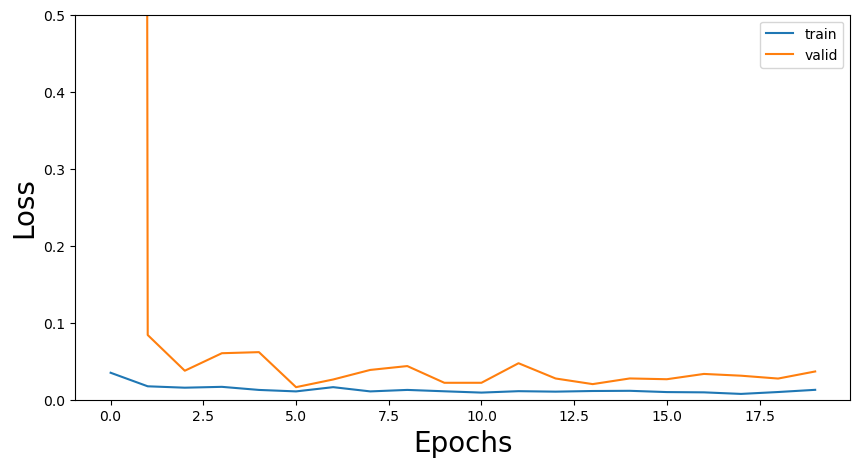

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.plot(valid_loss,label = 'valid')
plt.xlabel("Epochs",size = 20)
plt.ylabel("Loss", size = 20)
plt.ylim(0,0.5)
plt.legend()
plt.show()

## Plot images from test set and compare distances

In [ ]:
def show(img,ax,d):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    ax.set_title("Dissimilarity:"+str(round(d[0],5)),fontweight = "bold", size = 24)
    ax.set_xticks([])
    ax.set_yticks([])

FileNotFoundError: [Errno 2] No such file or directory: 'train_test_val/valid/Y24587/Y24587_s.jpg'

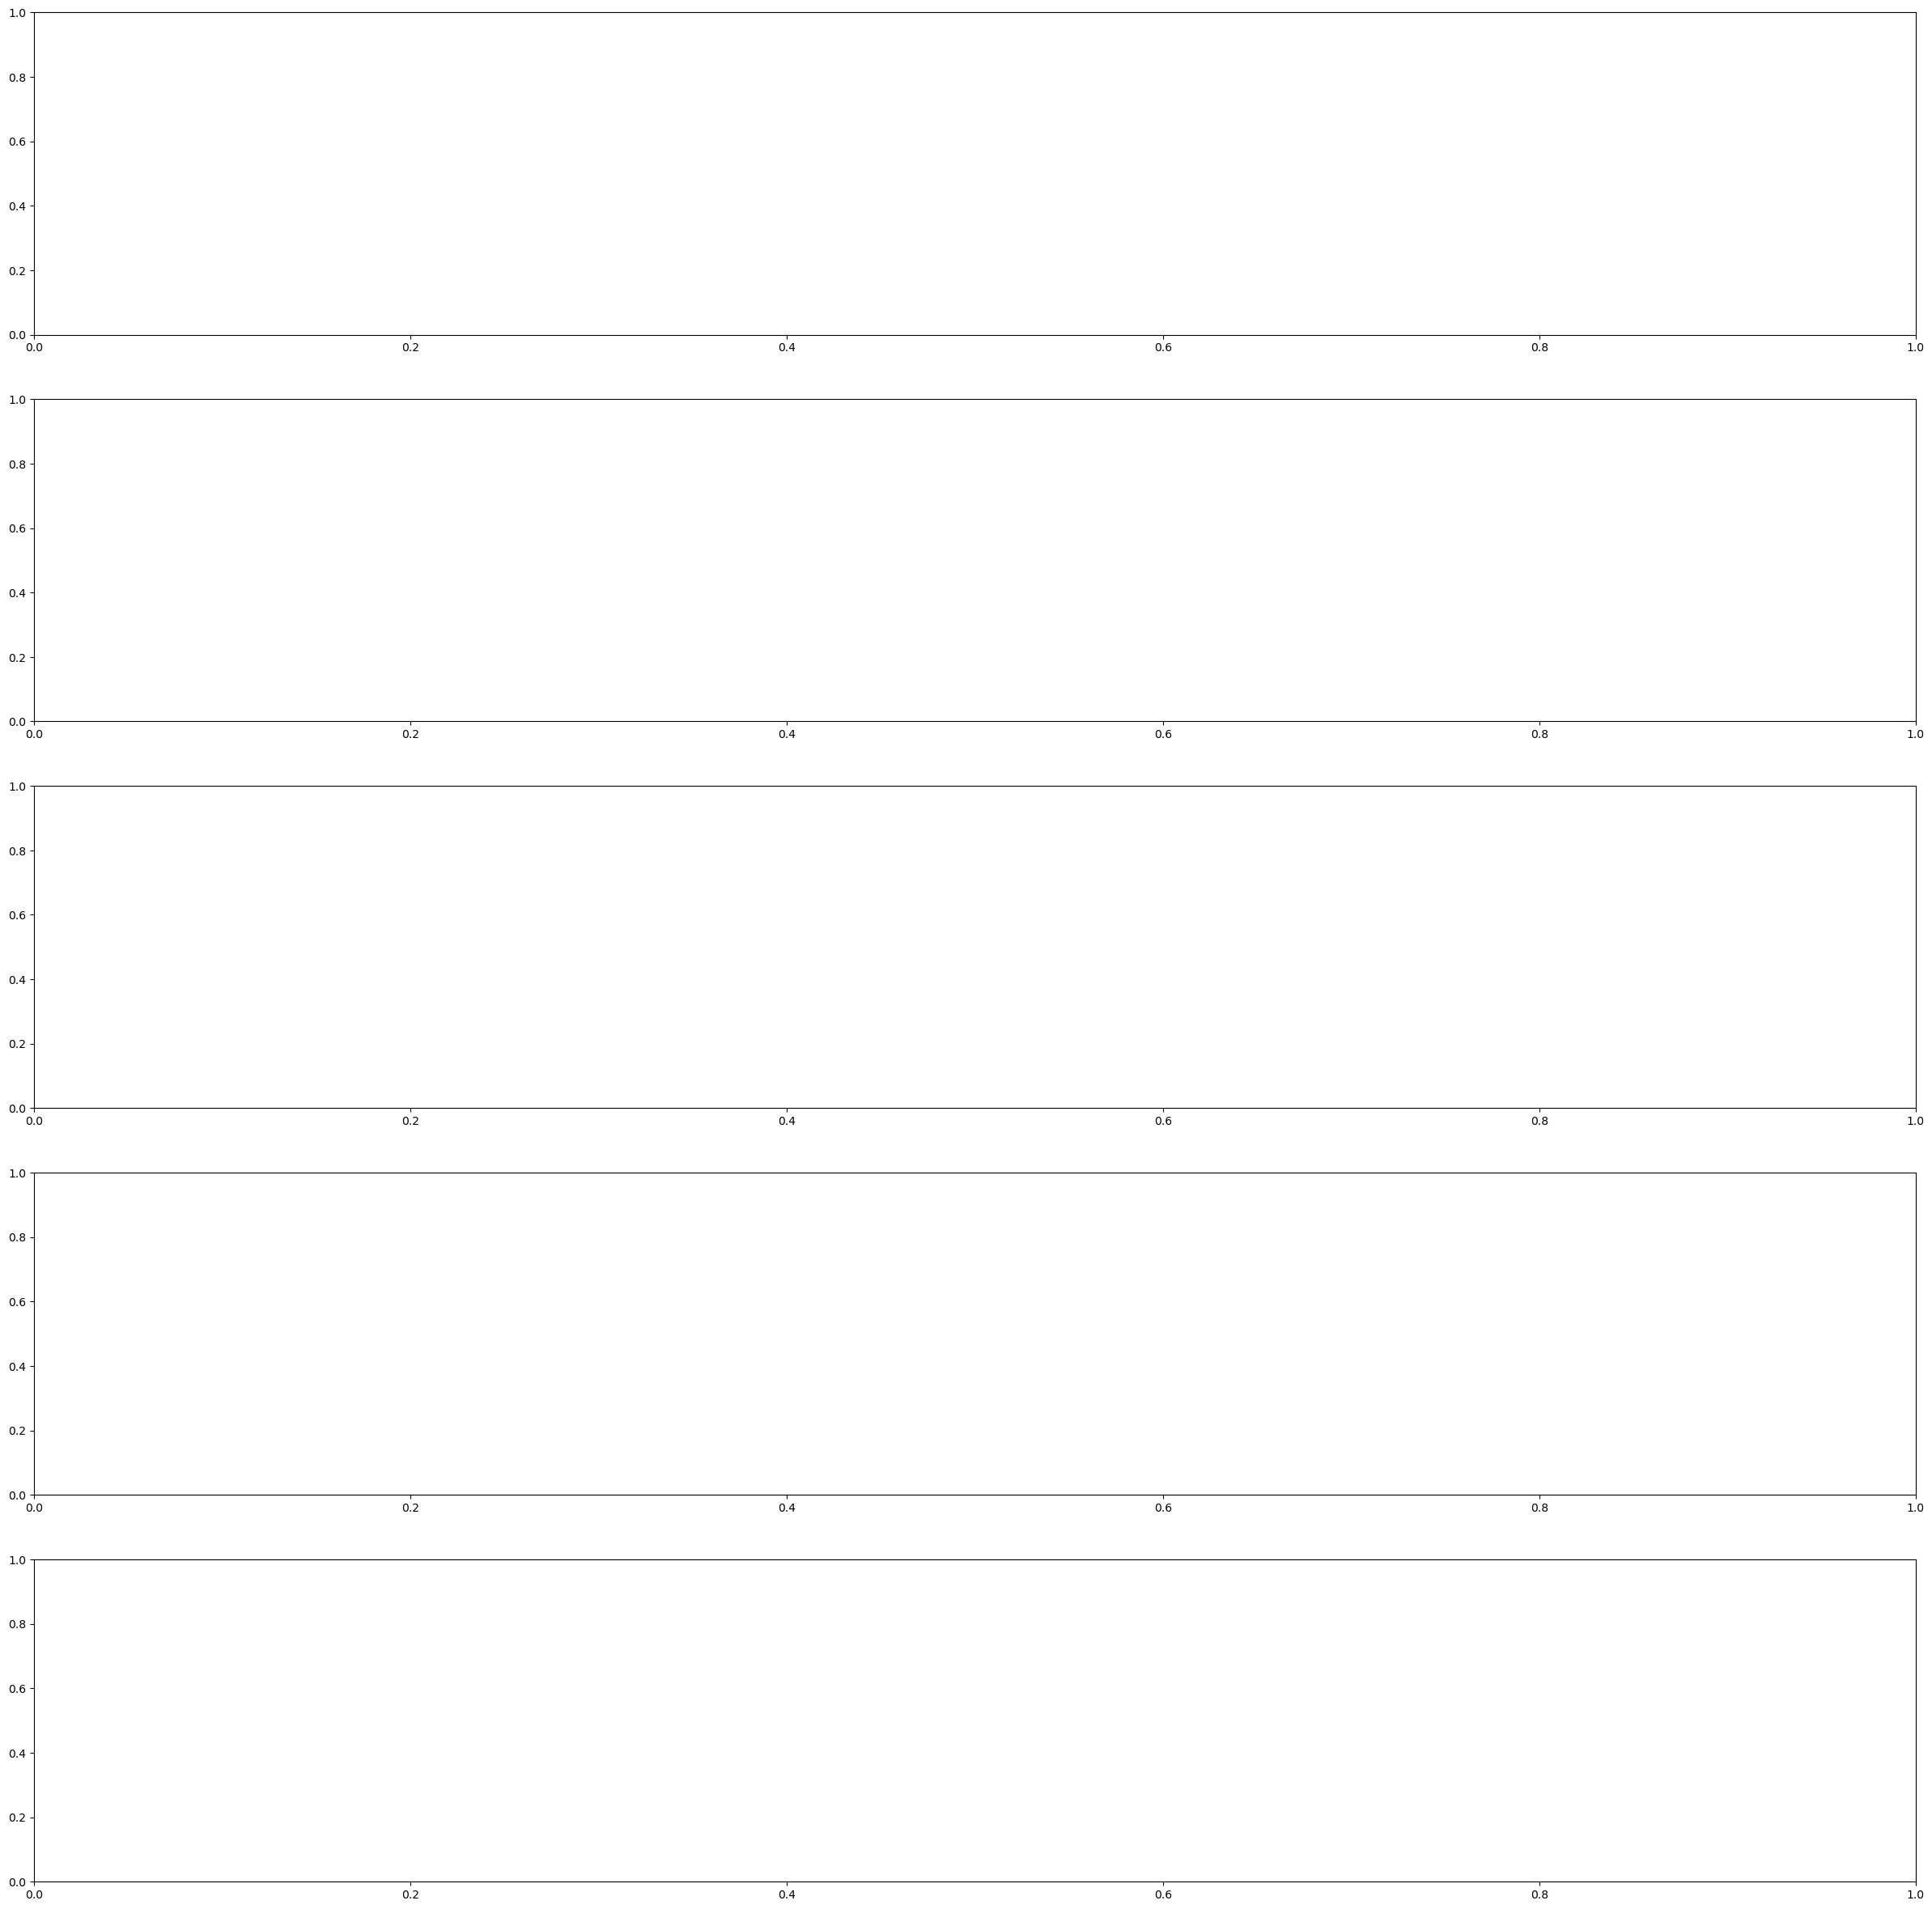

In [ ]:
fig,ax = plt.subplots(5,1,figsize = (30,30))
for i in range(5):
    idx = np.random.randint(0,len(valid_ds))
    input1,input2,target = valid_ds[idx]
    model=model.to(device)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    grid = torchvision.utils.make_grid([input1,input2])
    euclidean_distance = F.pairwise_distance(output1,output2)
    
    show(grid,ax[i],euclidean_distance.cpu().detach().numpy())
plt.show()

In [ ]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in train_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85        37
           1       0.72      0.91      0.81        23

    accuracy                           0.83        60
   macro avg       0.83      0.85      0.83        60
weighted avg       0.85      0.83      0.84        60



In [ ]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in test_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.40      1.00      0.57         2

    accuracy                           0.70        10
   macro avg       0.70      0.81      0.67        10
weighted avg       0.88      0.70      0.73        10



In [ ]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in valid_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.50      0.60      0.55         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.50      0.50      0.49        10



In [ ]:
from PIL import Image
def get_image_embedding(img_path):
    convert_tensor = torchvision.transforms.ToTensor()
    embd=model.forward_once(convert_tensor(Image.open(img_path).convert("RGB")).unsqueeze(0)).squeeze()
    return embd

get_image_embedding("00118_1_F.png")

FileNotFoundError: [Errno 2] No such file or directory: '00118_1_F.png'

## Save the trained model for future usage

In [ ]:
torch.save(model.state_dict(),'./siameseNetowrk_final.pt')

In [ ]:
new_model = SiameseNetwork()
new_model.load_state_dict(torch.load('./siameseNetowrk_final.pt'))
new_model.eval()

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(